<a href="https://colab.research.google.com/github/Paradorn657/recurrent_nearal/blob/master/Cnns_wavenet_forecast_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

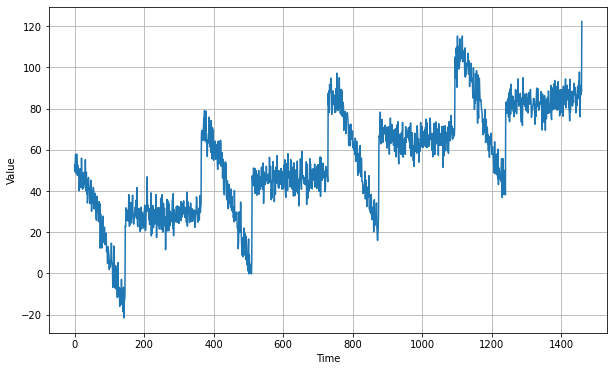

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model.compile(loss=keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])


model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

model = keras.models.load_model("my_checkpoint.h5")

Epoch 1/500
8/8 [==============================] - 1s 72ms/step - loss: 37.7036 - mae: 38.5999 - val_loss: 60.1515 - val_mae: 60.6228
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 25.4953 - mae: 26.6942 - val_loss: 32.5073 - val_mae: 33.1322
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 19.8446 - mae: 20.3975 - val_loss: 28.6865 - val_mae: 29.5706
Epoch 4/500
8/8 [==============================] - 0s 21ms/step - loss: 15.5266 - mae: 16.1783 - val_loss: 23.2081 - val_mae: 23.4307
Epoch 5/500
8/8 [==============================] - 0s 22ms/step - loss: 11.7850 - mae: 12.3773 - val_loss: 13.1255 - val_mae: 13.6019
Epoch 6/500
8/8 [==============================] - 0s 21ms/step - loss: 8.3289 - mae: 8.8893 - val_loss: 9.7710 - val_mae: 10.2356
Epoch 7/500
8/8 [==============================] - 0s 21ms/step - loss: 7.0838 - mae: 7.6006 - val_loss: 8.2854 - val_mae: 8.7998
Epoch 8/500
8/8 [==============================] - 0s 21ms/step - los

In [0]:
cnn_forecast = model_forecast(model, series[...,np.newaxis], window_size) # โยนซีรีย์เข้าไปหมดเลย series[...,np.newaxis] แล้ว เลือกเอา valid ออกมา -1,0 คือ ทำให้เหลือ 461 อย่างเดียว
cnn_forecast = cnn_forecast[split_time - window_size+1:,  -1,0]

In [29]:
cnn_forecast.shape

(461,)

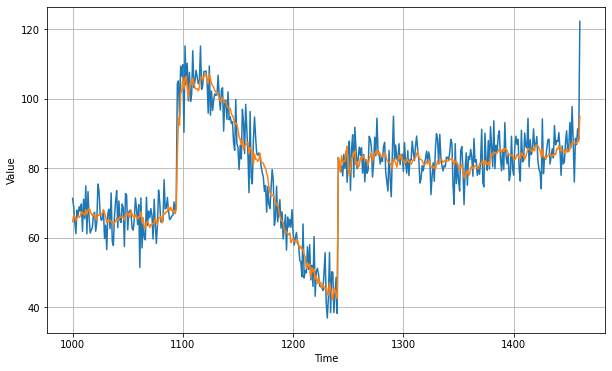

In [30]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [31]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

3.9689653